In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [6]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_merged = uvel_merged.isel(time=slice(771-42,900)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(771-42,900)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [7]:
def lanczos(x, a):
    return np.sinc(x/a)

In [8]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [9]:
nofiles=57
u_eul_filtered = uvel_merged.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
v_eul_filtered = vvel_merged.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_eul_filtered = u_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [10]:
#Load Lag data
lag_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_2_vels/lag_unfiltered_time2.zarr')
lag_filtered = xr.open_zarr('/swot/SUM03/spencer/time_2_vels/lag_filtered_time2.zarr')
u_unfiltered = lag_unfiltered.u
v_unfiltered = lag_unfiltered.v
u_filtered = lag_filtered.u
v_filtered = lag_filtered.v

In [12]:
u_filtered#.isel(time=0).plot(x='i')

<xarray.DataArray 'u' (time: 57, i: 2160, j: 2160)>
dask.array<open_dataset-9975cf0dc9462114929f09e525c6938fu, shape=(57, 2160, 2160), dtype=float64, chunksize=(1, 180, 180), chunktype=numpy.ndarray>
Coordinates:
    niter    int64 ...
  * time     (time) int64 0 3600 7200 10800 ... 190800 194400 198000 201600
    x0       (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0       float64 ...
Dimensions without coordinates: i, j
Attributes:
    units:    m/s

In [13]:
with ProgressBar():
    uhat_un = xrft.power_spectrum(u_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat_un = xrft.power_spectrum(v_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    uhat2 = xrft.power_spectrum(u_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(v_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    uhat2eul = xrft.power_spectrum(u_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2eul = xrft.power_spectrum(v_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
ekehat_eul = .5*(uhat2eul + vhat2eul)
ekehat = .5*(uhat2 + vhat2)
ekehat_un = .5*(uhat_un + vhat_un)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 20.4s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 19.0s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 20.3s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 22.1s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 15.5s
[                                        ] | 0% Completed |  0.0s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 18.1s


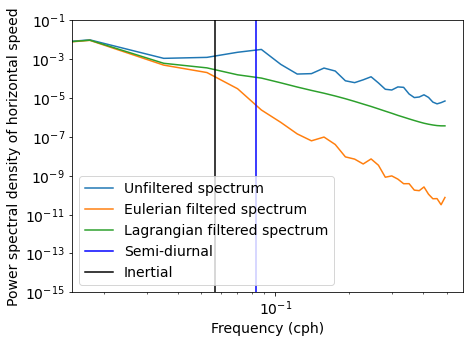

In [17]:
plt.figure(figsize=(7,5))
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).assign_coords(freq_time=ekehat_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered spectrum')
(ekehat_eul*ekehat_eul.freq_time).assign_coords(freq_time=ekehat_eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered spectrum')
(ekehat*ekehat.freq_time).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered spectrum')


plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.legend()
plt.ylim(10**-15,10**-1)

plt.ylabel('Power spectral density of horizontal speed')
plt.xlabel('Frequency (cph)')
plt.title('')

fig = plt.gcf()
fig.savefig("spectrum_2.png")

In [21]:
ekehat_un.freq_time*3600*2

<xarray.DataArray 'freq_time' (freq_time: 57)>
array([-0.98245614, -0.94736842, -0.9122807 , -0.87719298, -0.84210526,
       -0.80701754, -0.77192982, -0.73684211, -0.70175439, -0.66666667,
       -0.63157895, -0.59649123, -0.56140351, -0.52631579, -0.49122807,
       -0.45614035, -0.42105263, -0.38596491, -0.35087719, -0.31578947,
       -0.28070175, -0.24561404, -0.21052632, -0.1754386 , -0.14035088,
       -0.10526316, -0.07017544, -0.03508772,  0.        ,  0.03508772,
        0.07017544,  0.10526316,  0.14035088,  0.1754386 ,  0.21052632,
        0.24561404,  0.28070175,  0.31578947,  0.35087719,  0.38596491,
        0.42105263,  0.45614035,  0.49122807,  0.52631579,  0.56140351,
        0.59649123,  0.63157895,  0.66666667,  0.70175439,  0.73684211,
        0.77192982,  0.80701754,  0.84210526,  0.87719298,  0.9122807 ,
        0.94736842,  0.98245614])
Coordinates:
    niter      int64 0
    z0         float64 -0.5
  * freq_time  (freq_time) float64 -0.0001365 -0.0001316 ... 0.0001316 0.0001365

In [18]:
z_un=u_unfiltered.drop('niter')+1j*v_unfiltered.drop('niter')
z_f=u_filtered.drop('niter')+1j*v_filtered.drop('niter')
z_ef=u_eul_filtered+1j*v_eul_filtered
with ProgressBar():
    z2_un = xrft.power_spectrum(z_un.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
    z2_f = xrft.power_spectrum(z_f.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
    z2_ef = xrft.power_spectrum(z_ef.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 42.3s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 39.5s
[                                        ] | 0% Completed |  0.0s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 20.9s


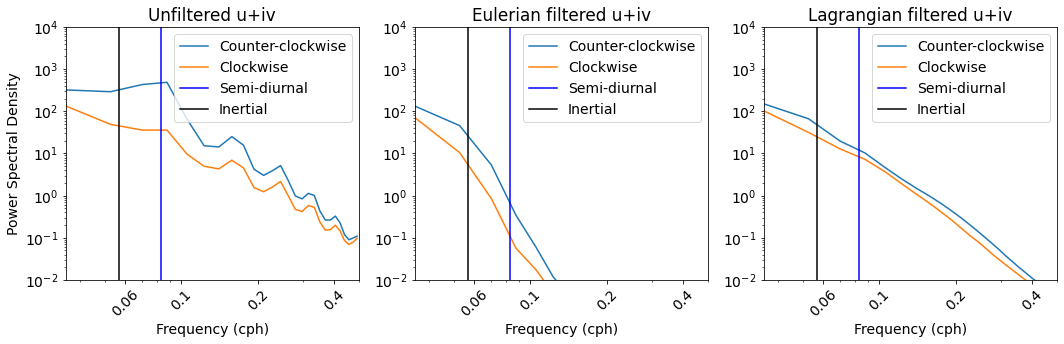

In [22]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(z2_un.freq_time[spec0:]*3600,z2_un.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_un.freq_time[spec0::-1]*3600,z2_un.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered u+iv')
plt.ylim(10**-2,10**4)
plt.xlim(0.035,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(z2_ef.freq_time[spec0:]*3600,z2_ef.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_ef.freq_time[spec0::-1]*3600,z2_ef.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered u+iv')
plt.ylim(10**-2,10**4)
plt.xlim(0.035,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(133)
plt.plot(z2_f.freq_time[spec0:]*3600,z2_f.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_f.freq_time[spec0::-1]*3600,z2_f.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered u+iv')
plt.ylim(10**-2,10**4)
plt.xlim(0.035,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('Rotary_filt_unfilt2.png')

In [ ]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
u_filtered = u_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
u_filtered = u_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
v_filtered = v_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
v_filtered = v_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
u_unfiltered = u_unfiltered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
u_unfiltered = u_unfiltered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
v_unfiltered = v_unfiltered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
v_unfiltered = v_unfiltered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})

In [ ]:
lons, lats = np.meshgrid(u_filtered.x0.values, u_filtered.y0.values)

In [ ]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [ ]:
u_eul_resampled = ufunc_resample(u_eul_filtered.load())
v_eul_resampled = ufunc_resample(v_eul_filtered.load())
u_resampled = ufunc_resample(u_filtered.load())
v_resampled = ufunc_resample(v_filtered.load())
u_resampled_unfilt = ufunc_resample(u_unfiltered.load())
v_resampled_unfilt = ufunc_resample(v_unfiltered.load())

In [ ]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [ ]:
def lin_func(s, a=1, b=1, c=1):
    x,y=s
    return a * x+ b * y + c

In [ ]:
fit_u = u_resampled_unfilt.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((u_resampled_unfilt.x1,u_resampled_unfilt.y1),fit_u.curvefit_coefficients.sel(param='a'), 
                       fit_u.curvefit_coefficients.sel(param='b'), fit_u.curvefit_coefficients.sel(param='c'))
u_resampled_unfilt_detr = (u_resampled_unfilt-fit_surface)

fit_u = u_resampled.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((u_resampled.x1,u_resampled.y1),fit_u.curvefit_coefficients.sel(param='a'), 
                       fit_u.curvefit_coefficients.sel(param='b'), fit_u.curvefit_coefficients.sel(param='c'))
u_resampled_detr = (u_resampled-fit_surface)



In [ ]:
fit_v = v_resampled_unfilt.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((v_resampled_unfilt.x1,v_resampled_unfilt.y1),fit_v.curvefit_coefficients.sel(param='a'), 
                       fit_v.curvefit_coefficients.sel(param='b'), fit_v.curvefit_coefficients.sel(param='c'))
v_resampled_unfilt_detr = (v_resampled_unfilt-fit_surface)

fit_v = v_resampled.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((v_resampled.x1,v_resampled.y1),fit_v.curvefit_coefficients.sel(param='a'), 
                       fit_v.curvefit_coefficients.sel(param='b'), fit_v.curvefit_coefficients.sel(param='c'))
v_resampled_detr = (v_resampled-fit_surface)


In [ ]:
with ProgressBar():
    u2_ps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_ps_unfilt_detr = xrft.power_spectrum(u_resampled_unfilt_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilt_detr = xrft.power_spectrum(v_resampled_unfilt_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_ps_detr = xrft.power_spectrum(u_resampled_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_detr = xrft.power_spectrum(v_resampled_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_unfilt = (u2_ps_unfilt + v2_ps_unfilt)*0.5
vel_ps_unfilt_detr = (u2_ps_unfilt_detr + v2_ps_unfilt_detr)*0.5

vel_ps = (u2_ps + v2_ps)*0.5
vel_ps_detr = (u2_ps_detr + v2_ps_detr)*0.5

In [ ]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [ ]:

ps_iso_unfilt = iso_spec(vel_ps_unfilt)
ps_iso_unfilt_detr = iso_spec(vel_ps_unfilt_detr)
ps_iso = iso_spec(vel_ps)
ps_iso_detr = iso_spec(vel_ps_detr)

In [ ]:
kr    = ps_iso_unfilt.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked


([<matplotlib.axis.YTick at 0x7f2bf422c110>,
 [Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4')])

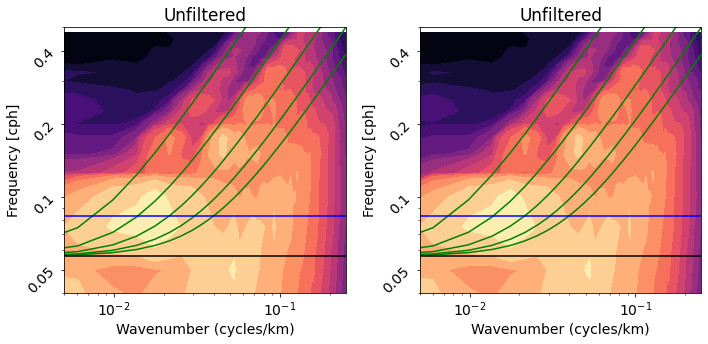

In [128]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso_unfilt.freq_time*3600
kr    = ps_iso_unfilt.kr
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt_detr,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked


([<matplotlib.axis.YTick at 0x7f2af43512d0>,
 [Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4')])

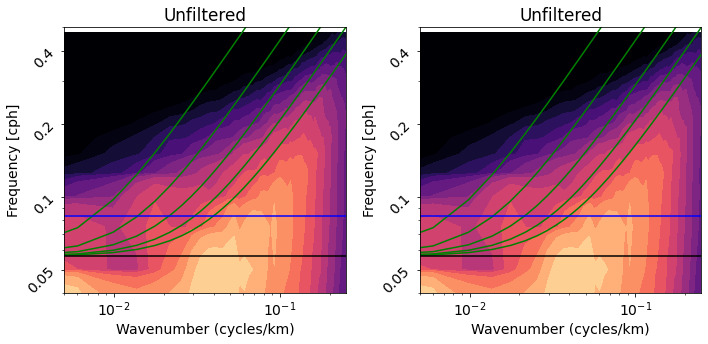

In [129]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso_unfilt.freq_time*3600
kr    = ps_iso_unfilt.kr
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_detr,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)